In [1]:
"""
### 객체 탐지

#텐서플로우 허브 활용

이번에는 텐서플로우 허브에서 제공하는 객체 탐지 모델을 사용하여 샘플 이미지로부터
객체를 추출하는 작업을 한다 

"""
import tensorflow as tf 
import tensorflow_hub as tfhub

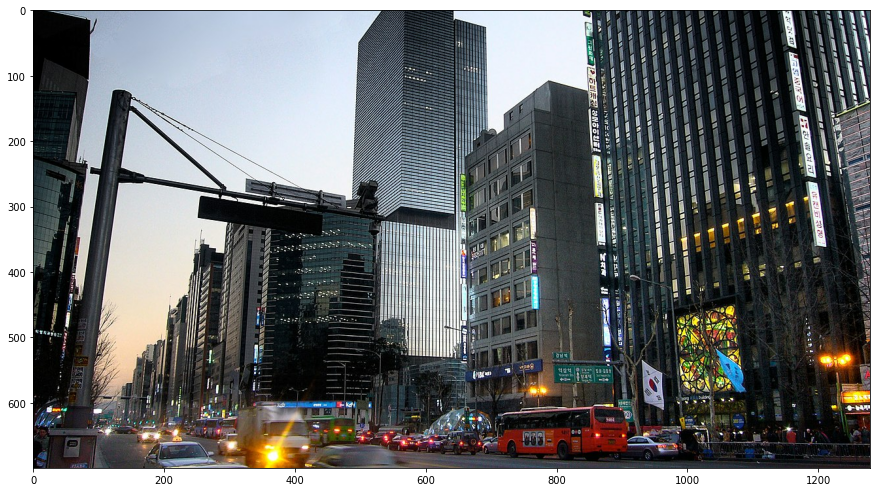

In [2]:
"""
샘플 이미지 준비

이미 학습이 완료된 딥러닝 모델을 사용할 것이므로, 별도로 모델 학습을 하지 않는다
모델을 활용해 객체를 탐지하고 검출할 샘플 이미지를 준비한다
여기서는 위키피디아에서 제공하는 서울 강남 지역의 거리 사진을 다운로드 받아서 
모델의 입력 형태에 맞게 전처리
"""
#샘플 이미지 다운로드
img_path = 'https://upload.wikimedia.org/wikipedia/commons/thumb/c/c4/Gangnam_Seoul_January_2009.jpg/1280px-Gangnam_Seoul_January_2009.jpg'
img = tf.keras.utils.get_file(fname = "gangnam", origin=img_path)
img = tf.io.read_file(img) # 파일 객체를 straing으로 변환
img = tf.image.decode_jpeg(img, channels =3)  # 문자(string)를 숫자(unit8)텐서로 변환
img = tf.image.convert_image_dtype(img, tf.float32)  # 0~1 범위로 정규화

import matplotlib.pylab as plt
plt.figure(figsize=(15,10))
plt.imshow(img)

In [3]:
img_input = tf.expand_dims(img, 0) # batch_size 추가
img_input.shape

TensorShape([1, 700, 1280, 3])

In [4]:
# TensorFlow Hub에서 모델 가져오기 - FasterRCNN+InceptionResNet V2 
model = tfhub.load("https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1")

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [5]:
# 모델 시그니처(용도) 확인 
model.signatures.keys()

KeysView(_SignatureMap({'default': <ConcreteFunction pruned(images) at 0x1B4B200C0A0>}))

In [6]:
#모델에서 default 시그니처를 지정하여 객체 탐지 모델 인스턴스를 생성
#객체 탐지 모델 생성
obj_detector = model.signatures["default"]
obj_detector 

<ConcreteFunction pruned(images) at 0x1B4B200C0A0>

In [7]:
"""
# 추론
"""
#모델을 이용하여 예측(추론)
result = obj_detector(img_input)
result.keys()

dict_keys(['detection_class_names', 'detection_class_labels', 'detection_boxes', 'detection_class_entities', 'detection_scores'])

In [9]:
"""
detection_boxes : 경계 박스
detection_class_entities : 검출된 클래스 아이디
detection_scores : 검출 스코어
다음 값들을 사용할 예정
"""
# 탐지한 객체의 개수
len(result["detection_scores"])

100

In [10]:
"""
검출된 100개의 객체중에서 검출 스코어가 0.1보다 큰 경우만 경계 박스와 예측 클래스를 
시각화 한다
최대 10개 객체만 표시되도록 설정
"""
boxes = result["detection_boxes"]  # bounding box 좌표 예측 값
labels = result["detection_class_entities"]  # 분류 예측 값
scores = result["detection_scores"]   # 신뢰되(confidence)

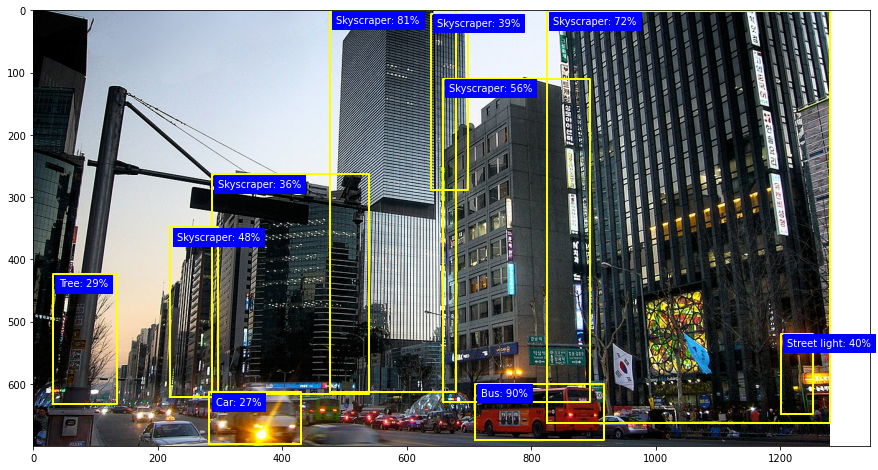

In [12]:
# 샘플 이미지 가로 세로 크기
img_height, img_width = img.shape[0], img.shape[1]

# 탐지할 최대 객체의 수
obj_to_detect = 10

# 시각화
plt.figure(figsize=(15, 10))
for i in range(min(obj_to_detect, boxes.shape[0])):    
    if scores[i] >= 0.2:
        (ymax, xmin, ymin, xmax) = (boxes[i][0]*img_height, boxes[i][1]*img_width,
                                    boxes[i][2]*img_height, boxes[i][3]*img_width)
                                    
        plt.imshow(img)
        plt.plot([xmin, xmax, xmax, xmin, xmin], [ymin, ymin, ymax, ymax, ymin],
                 color='yellow', linewidth=2)
        
        class_name = labels[i].numpy().decode('utf-8')
        infer_score = int(scores[i].numpy()*100)
        annotation = "{}: {}%".format(class_name, infer_score)
        plt.text(xmin+10, ymax+20, annotation,
                 color='white', backgroundcolor='blue', fontsize=10)